# **(How to) Use Cohen's kappa for your binary classification models!** - 5 minutes of fame
## *6 May 2022 @ CzodrowskiLab*

## Aishvarya Tandon
* PhD student - CzodrowskiLab / Waldmann group
* Contact information: [Email](mailto:aishvarya.tandon@tu-dortmund.de), [GitHub](https://github.com/aish-tan)

We love using Cohen's kappa in our group as a metric for testing our binary classification models. In this notebook, I will give a quick demo on how you can use Cohen's kappa for your binary classification models and make them great again!

The following work is based on my opinion. Credits of all the software used and demonstrated belongs to their respective authors and the community.

**License**: MIT

### **What is Cohen's kappa?**

Cohen's kappa, or simply kappa, was introduced by [Jacob Cohen](https://en.wikipedia.org/wiki/Jacob_Cohen_(statistician)) in 1960. 

**Some definitions:**

* Cohen defined kappa in the original paper as:
>The coefficient $k$ is simply the proportion of chance-expected disagreements which do not occur.

* The [Wikipedia](https://en.wikipedia.org/wiki/Cohen%27s_kappa) definition reads, "Cohen's kappa coefficient is a statistic that is used to measure inter-rater reliability for qualitative items".  

* [Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) definition reads, "a score that expresses the level of agreement between two annotators on a classification problem". The formula:
$$\kappa = (p_{o} - p_{e})/(1 - p_{e})$$
where,
$p_{o}$ = empirical probability of agreement on the label assigned to any sample (the observed agreement ratio) and,
$p_{e}$ = the expected agreement when both annotators assign labels randomly


It is also commonly used by Cheminformaticians to evaluate their classification models more transparently rather than just using accuracy as metrics. 

Good reads:

1. In the original [publication](https://doi.org/10.1177%2F001316446002000104)
2. In Prof. Czodrowski's paper - ["Count on kappa"](https://doi.org/10.1007/s10822-014-9759-6)
3. Many tutorials present online!

### How to calculate kappa for your models?

The easiest way to calculcate kappa for your models is to use the ['cohen_kappa_score'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) function offered by the Scikit learn package! That's it!

In [1]:
from sklearn.metrics import cohen_kappa_score

Once your model's predictions are ready, you can use this function as:

`cohen_kappa_score(original values, predicted values)`

Kappa values range from -1 to 1. If the score is below 0, it means that the model is predicting worse than random prediction, and the value of 1 indicate a perfect model. While there are no definite standards for which value of kappa should your models really have - the rule of thumb simply is that the higher value of kappa your model has, the better it is (without falling in the trap of overfitting). 

Let's get modelling!
I will use my same toy example I used last time in my Optuna 5 mins of fame notebook.
>#### **Toy problem:** Models to predict a molecule's average molecular weight from its 2D fingerprint.
Let us prepare data and input strategy which we will use repeatedly in advance.
I will import a subset of randomly selected 50000 compounds from CHEMBL 29

The only difference this time is that we predict sn arbitrary weight class instead of performing regression.

In [2]:
import pandas as pd
df = pd.read_parquet('Shortlisted_Chembl29-4Feb2022.parquet.gzip')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   chembl_id  50000 non-null  object
 1   InChIKey   50000 non-null  object
 2   Smiles     50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


,chembl_id,InChIKey,Smiles
0,CHEMBL424856,KNZSNTNUOIRWRE-UHFFFAOYSA-N,CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21
1,CHEMBL3792491,NTQFMRZDTVXICG-UHFFFAOYSA-N,CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC
2,CHEMBL3900710,IRTOHFGPHMCDRK-UHFFFAOYSA-N,Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...
3,CHEMBL35988,YBIWOQATDVKIPT-UHFFFAOYSA-N,CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1
4,CHEMBL3452898,MMMKGEGGKRMNHL-UHFFFAOYSA-N,Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O


#### Let us use RDKit's Descriptor module to calculate average molecular weight of these compounds

In [3]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors, MolFromSmiles

df['MolWt'] = df['Smiles'].apply(lambda x: Descriptors.MolWt(MolFromSmiles(x)))
df.head()

,chembl_id,InChIKey,Smiles,MolWt
0,CHEMBL424856,KNZSNTNUOIRWRE-UHFFFAOYSA-N,CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21,389.126
1,CHEMBL3792491,NTQFMRZDTVXICG-UHFFFAOYSA-N,CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC,440.584
2,CHEMBL3900710,IRTOHFGPHMCDRK-UHFFFAOYSA-N,Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...,500.986
3,CHEMBL35988,YBIWOQATDVKIPT-UHFFFAOYSA-N,CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1,311.410
4,CHEMBL3452898,MMMKGEGGKRMNHL-UHFFFAOYSA-N,Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O,353.403


#### Generating Morgan fingerprints of n_bits = 2048 and radius 3

In [4]:
from rdkit import DataStructs
import numpy as np

def fetch_fp(smile):
    fp = Chem.GetMorganFingerprintAsBitVect(MolFromSmiles(smile), 3, nBits = 2048)
    arr = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    return(arr)

In [5]:
df['Fingerprint'] = df['Smiles'].map(fetch_fp)
df.head()

,chembl_id,InChIKey,Smiles,MolWt,Fingerprint
0,CHEMBL424856,KNZSNTNUOIRWRE-UHFFFAOYSA-N,CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21,389.126,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3792491,NTQFMRZDTVXICG-UHFFFAOYSA-N,CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC,440.584,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3900710,IRTOHFGPHMCDRK-UHFFFAOYSA-N,Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...,500.986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL35988,YBIWOQATDVKIPT-UHFFFAOYSA-N,CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1,311.410,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3452898,MMMKGEGGKRMNHL-UHFFFAOYSA-N,Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O,353.403,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Let us see a distribution of MolWt

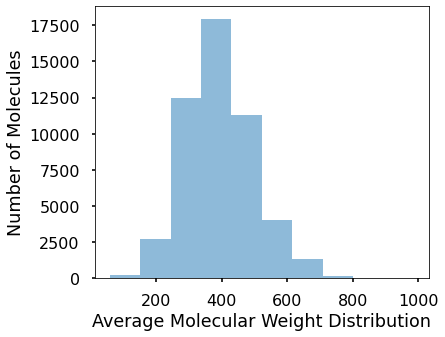

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-poster")

df.MolWt.plot.hist(alpha=0.5, figsize=(6, 5))
plt.xlabel('Average Molecular Weight Distribution')
plt.ylabel('Number of Molecules')

plt.show()

Let's arbitrary designate all the molecules which have molecular weight below 400 in class 0 and the rest in class 1. 

In [7]:
df.loc[df['MolWt'] < 400, 'Weight_Class'] = 0
df.loc[df['MolWt'] >= 400, 'Weight_Class'] = 1
feat = 'Weight_Class'

df.head()

,chembl_id,InChIKey,Smiles,MolWt,Fingerprint,Weight_Class
0,CHEMBL424856,KNZSNTNUOIRWRE-UHFFFAOYSA-N,CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21,389.126,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,CHEMBL3792491,NTQFMRZDTVXICG-UHFFFAOYSA-N,CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC,440.584,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,CHEMBL3900710,IRTOHFGPHMCDRK-UHFFFAOYSA-N,Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...,500.986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
3,CHEMBL35988,YBIWOQATDVKIPT-UHFFFAOYSA-N,CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1,311.410,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,CHEMBL3452898,MMMKGEGGKRMNHL-UHFFFAOYSA-N,Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O,353.403,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


In [8]:
df[feat].value_counts()

0.0    27805
1.0    22195
Name: Weight_Class, dtype: int64

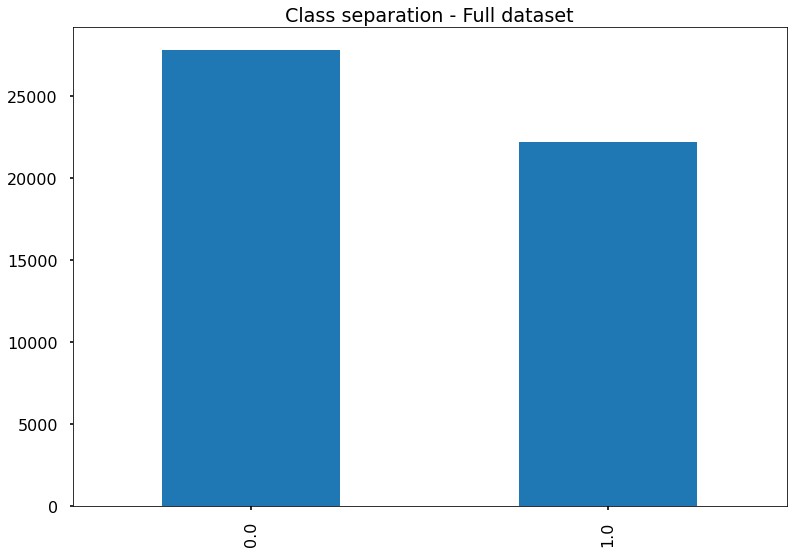

In [9]:
df[feat].value_counts().plot(kind='bar')
plt.title("Class separation - Full dataset")
plt.show()
#Hmm, almost balanced!

In [10]:
#Let's define X = fingerprints and Y as class

In [11]:
X = np.stack(df.Fingerprint)
X.shape

(50000, 2048)

In [12]:
type(X)

numpy.ndarray

In [13]:
Y = df[feat].copy()
Y = Y.to_numpy()
Y.shape

(50000,)

In [14]:
type(Y)

numpy.ndarray

In [15]:
#Dividing into training and test sets
import sklearn.model_selection as model_selection

X_train, X_test, Y_train, Y_test  = model_selection.train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify= df[feat])
#stratifying because it's always a good idea to maintain the same balance of classes in test-training sets

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (40000, 2048)
X_test shape: (10000, 2048)
Y_train shape: (40000,)
Y_test shape: (10000,)


In [17]:
#Using XGBoost classifier
from xgboost import XGBClassifier

clf = XGBClassifier(use_label_encoder = False)
clf.fit(X_train, Y_train)

[16:29:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=96,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [18]:
Y_pred = clf.predict(X_test)

In [19]:
df_test = pd.DataFrame()
df_test['Weight_Class_Original'] = Y_test
df_test['Weight_Class_Predicted'] = Y_pred
df_test.head()

,Weight_Class_Original,Weight_Class_Predicted
0,1.0,1
1,0.0,0
2,0.0,0
3,1.0,1
4,0.0,0


In [20]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

balanced_accuracy_score(df_test['Weight_Class_Original'], df_test['Weight_Class_Predicted'])

0.8331402898059204

In [21]:
cohen_kappa_score(df_test['Weight_Class_Original'], df_test['Weight_Class_Predicted'])

0.6698886565596525

In [22]:
#confusion matrix
cm = confusion_matrix(df_test['Weight_Class_Original'], df_test['Weight_Class_Predicted'])
cm

array([[4869,  692],
       [ 929, 3510]])

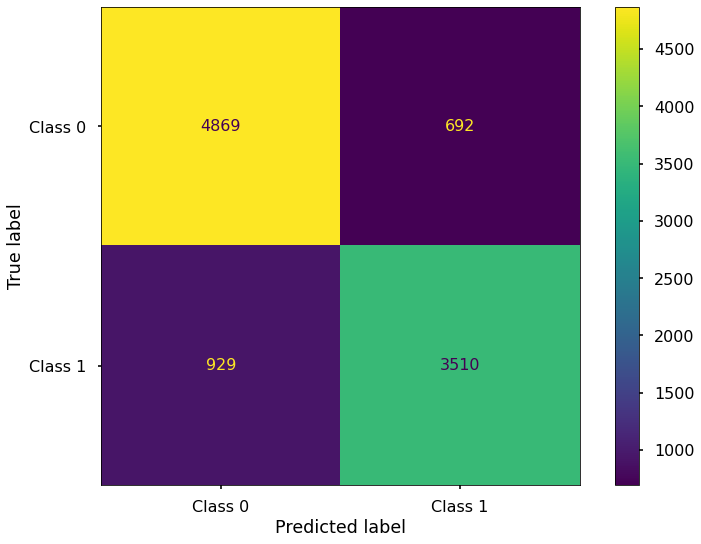

In [23]:
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

disp.plot()

plt.show()

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("seaborn-poster")

Remember k-fold cross validation? It is a necessary technique to check the model's performance on the data distribution. Since Scikit-Learn already offers amazing k-fold cross validation, we are going to see that

To simply get single metric cross validation score, one can use `cross_val_score` function.

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

skfold = StratifiedKFold(n_splits=10, shuffle = True) #in case your data has imbalanced classes

scores = cross_val_score(clf, X_train, Y_train, cv=skfold, 
                          scoring = 'balanced_accuracy')

[16:30:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:09] WARNING: /home

In [26]:
print(f"All scores (balanced accuracy): {scores}")
print(f"Mean score: {np.mean(scores)}")

All scores (balanced accuracy): [0.83664892 0.83320776 0.8335541  0.84847325 0.83253735 0.82398001
 0.83779712 0.8273366  0.838025   0.83454661]
Mean score: 0.8346106720120838


But wait - why not use kappa instead? By default, kappa is not present as a scoring metric here.

In [27]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

However, we can use another scikit-learn function called `make_scorer` to help us!

In [28]:
from sklearn.metrics import make_scorer
kappa = make_scorer(cohen_kappa_score)

Now, we can use this as the metric

In [29]:
scores = cross_val_score(clf, X_train, Y_train, cv=skfold, 
                          scoring = kappa)

[16:32:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:45] WARNING: /home

In [30]:
print(f"All scores (kappa): {scores}")
print(f"Mean score: {np.mean(scores)}")

All scores (kappa): [0.65295048 0.66024027 0.67454018 0.66582444 0.68299982 0.67551226
 0.66243648 0.68771258 0.66951211 0.69641595]
Mean score: 0.6728144575100473


What if we need to see both? Here, we use the basic `cross_validate` function and prepare a dictionary object and mention our desired metrics.

In [31]:
scoring = {'kappa': make_scorer(cohen_kappa_score), 'balanced_accuracy': 'balanced_accuracy'}

scores = cross_validate(clf, X_train, Y_train, cv= skfold, scoring=scoring, 
                        return_train_score=True)

[16:35:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:28] WARNING: /home

This is definitely helpful!

In [32]:
scores

{'fit_time': array([16.2390995 , 15.64413095, 17.32682157, 16.77430058, 15.46730781,
        17.34694219, 14.27156854, 15.75041771, 15.71470928, 16.30757809]),
 'score_time': array([0.0177474 , 0.02533913, 0.0184288 , 0.01786327, 0.01758075,
        0.01867914, 0.02151871, 0.01818037, 0.02067971, 0.01625276]),
 'test_kappa': array([0.66643344, 0.65256582, 0.70060124, 0.67552181, 0.67612359,
        0.66858063, 0.65470194, 0.66611444, 0.68914227, 0.6627728 ]),
 'train_kappa': array([0.86868712, 0.87094032, 0.87330704, 0.870527  , 0.87376293,
        0.87223761, 0.87351328, 0.87282244, 0.86919915, 0.87338729]),
 'test_balanced_accuracy': array([0.83181833, 0.82478409, 0.84835375, 0.83574964, 0.8361446 ,
        0.83300117, 0.82501978, 0.83087514, 0.84241177, 0.82844121]),
 'train_balanced_accuracy': array([0.93194937, 0.93303677, 0.93418043, 0.93277355, 0.93441812,
        0.93366802, 0.93440274, 0.93382508, 0.93220794, 0.93429599])}

In [33]:
print(scores['test_kappa'])
print(np.mean(scores['test_kappa']))

[0.66643344 0.65256582 0.70060124 0.67552181 0.67612359 0.66858063
 0.65470194 0.66611444 0.68914227 0.6627728 ]
0.6712557995326514


In [34]:
print(scores['train_kappa'])
print(np.mean(scores['train_kappa']))

[0.86868712 0.87094032 0.87330704 0.870527   0.87376293 0.87223761
 0.87351328 0.87282244 0.86919915 0.87338729]
0.8718384181248758


In [35]:
print(scores['test_balanced_accuracy'])
print(np.mean(scores['test_balanced_accuracy']))

[0.83181833 0.82478409 0.84835375 0.83574964 0.8361446  0.83300117
 0.82501978 0.83087514 0.84241177 0.82844121]
0.8336599481346134


In [36]:
print(scores['train_balanced_accuracy'])
print(np.mean(scores['train_balanced_accuracy']))

[0.93194937 0.93303677 0.93418043 0.93277355 0.93441812 0.93366802
 0.93440274 0.93382508 0.93220794 0.93429599]
0.9334758010820359


Good, now your model is cross-validated!

Moving on - remember Optuna? The hyperparameter optimization software? Can we use Optuna to improve our models and keep kappa as the metric? 

**YES!**

Just for demo purpose, we try to optimize on these two hyperparameters (with rather limited number of trials).

In [37]:
import optuna

def xgb_class_objective(trial):
    
    # Optimizing the booster category.
    booster = trial.suggest_categorical('booster', ["gbtree", "gblinear", "dart"])
    
    #Optimizing the learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1.0, log=True)
    
    xgb_model = XGBClassifier(booster = booster, learning_rate = learning_rate, use_label_encoder = False)
    
    xgb_model.fit(X_train, Y_train)
    
    Y_test_pred_xgb = xgb_model.predict(X_test)
    
    return cohen_kappa_score(Y_test, Y_test_pred_xgb)

In [42]:
xgb_study = optuna.create_study(direction="maximize", study_name = 'xgb_model_optimization')
xgb_study.optimize(xgb_class_objective, n_trials=25)

[I 2022-05-06 16:48:50,237] A new study created in memory with name: xgb_model_optimization


[16:48:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:51:24,915] Trial 0 finished with value: 0.6705961571475392 and parameters: {'booster': 'dart', 'learning_rate': 0.684179941270936}. Best is trial 0 with value: 0.6705961571475392.


[16:51:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:53:22,756] Trial 1 finished with value: 0.482231819196995 and parameters: {'booster': 'dart', 'learning_rate': 0.016442867839891923}. Best is trial 0 with value: 0.6705961571475392.


[16:53:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:55:37,814] Trial 2 finished with value: 0.5780097176577736 and parameters: {'booster': 'dart', 'learning_rate': 0.051997326774248766}. Best is trial 0 with value: 0.6705961571475392.


[16:55:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:55:43,746] Trial 3 finished with value: 0.6432533402428393 and parameters: {'booster': 'gblinear', 'learning_rate': 0.04438430391332539}. Best is trial 0 with value: 0.6705961571475392.


[16:55:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:56:01,543] Trial 4 finished with value: 0.45467455885863506 and parameters: {'booster': 'gbtree', 'learning_rate': 0.011000851448863412}. Best is trial 0 with value: 0.6705961571475392.


[16:56:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:56:19,178] Trial 5 finished with value: 0.4998555663424741 and parameters: {'booster': 'gbtree', 'learning_rate': 0.020490458223439728}. Best is trial 0 with value: 0.6705961571475392.


[16:56:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:56:25,003] Trial 6 finished with value: 0.7389649083105647 and parameters: {'booster': 'gblinear', 'learning_rate': 0.4875157583190857}. Best is trial 6 with value: 0.7389649083105647.


[16:56:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:08,992] Trial 7 finished with value: 0.49638207046169847 and parameters: {'booster': 'dart', 'learning_rate': 0.019791477598571413}. Best is trial 6 with value: 0.7389649083105647.


[16:59:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:27,788] Trial 8 finished with value: 0.4547166088429222 and parameters: {'booster': 'gbtree', 'learning_rate': 0.01058067005492859}. Best is trial 6 with value: 0.7389649083105647.


[16:59:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:33,141] Trial 9 finished with value: 0.6706081330574805 and parameters: {'booster': 'gblinear', 'learning_rate': 0.07426964981298859}. Best is trial 6 with value: 0.7389649083105647.


[16:59:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:38,529] Trial 10 finished with value: 0.7334390947769636 and parameters: {'booster': 'gblinear', 'learning_rate': 0.4425110040666616}. Best is trial 6 with value: 0.7389649083105647.


[16:59:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:43,530] Trial 11 finished with value: 0.7352893475499198 and parameters: {'booster': 'gblinear', 'learning_rate': 0.42458100863743736}. Best is trial 6 with value: 0.7389649083105647.


[16:59:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:49,132] Trial 12 finished with value: 0.7247948618876944 and parameters: {'booster': 'gblinear', 'learning_rate': 0.25404045528234737}. Best is trial 6 with value: 0.7389649083105647.


[16:59:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 16:59:54,976] Trial 13 finished with value: 0.716806503661111 and parameters: {'booster': 'gblinear', 'learning_rate': 0.19522586629635386}. Best is trial 6 with value: 0.7389649083105647.


[16:59:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:00,266] Trial 14 finished with value: 0.752703018689343 and parameters: {'booster': 'gblinear', 'learning_rate': 0.9627924970653151}. Best is trial 14 with value: 0.752703018689343.


[17:00:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:06,285] Trial 15 finished with value: 0.7538939159421333 and parameters: {'booster': 'gblinear', 'learning_rate': 0.964716988644678}. Best is trial 15 with value: 0.7538939159421333.


[17:00:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:12,069] Trial 16 finished with value: 0.7570412913281664 and parameters: {'booster': 'gblinear', 'learning_rate': 0.9489282412041488}. Best is trial 16 with value: 0.7570412913281664.


[17:00:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:16,442] Trial 17 finished with value: 0.709545567341506 and parameters: {'booster': 'gblinear', 'learning_rate': 0.15429357147112652}. Best is trial 16 with value: 0.7570412913281664.


[17:00:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:21,928] Trial 18 finished with value: 0.7501367071616358 and parameters: {'booster': 'gblinear', 'learning_rate': 0.907788229599546}. Best is trial 16 with value: 0.7570412913281664.


[17:00:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:39,184] Trial 19 finished with value: 0.6727845703203266 and parameters: {'booster': 'gbtree', 'learning_rate': 0.3598793451125259}. Best is trial 16 with value: 0.7570412913281664.


[17:00:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:43,372] Trial 20 finished with value: 0.6892365249538013 and parameters: {'booster': 'gblinear', 'learning_rate': 0.0973085191673611}. Best is trial 16 with value: 0.7570412913281664.


[17:00:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:47,468] Trial 21 finished with value: 0.7568133303975737 and parameters: {'booster': 'gblinear', 'learning_rate': 0.9634133192176623}. Best is trial 16 with value: 0.7570412913281664.


[17:00:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:51,351] Trial 22 finished with value: 0.748912388335254 and parameters: {'booster': 'gblinear', 'learning_rate': 0.697172600079768}. Best is trial 16 with value: 0.7570412913281664.


[17:00:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:00:56,249] Trial 23 finished with value: 0.7458511052221715 and parameters: {'booster': 'gblinear', 'learning_rate': 0.6224916266333781}. Best is trial 16 with value: 0.7570412913281664.


[17:00:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-05-06 17:01:01,341] Trial 24 finished with value: 0.7261582202792175 and parameters: {'booster': 'gblinear', 'learning_rate': 0.27037483021584247}. Best is trial 16 with value: 0.7570412913281664.


In [43]:
print("Best params: ", xgb_study.best_params)
print("Best value: ", xgb_study.best_value)
print("Best Trial: ", xgb_study.best_trial)

Best params:  {'booster': 'gblinear', 'learning_rate': 0.9489282412041488}
Best value:  0.7570412913281664
Best Trial:  FrozenTrial(number=16, values=[0.7570412913281664], datetime_start=datetime.datetime(2022, 5, 6, 17, 0, 6, 287167), datetime_complete=datetime.datetime(2022, 5, 6, 17, 0, 12, 69641), params={'booster': 'gblinear', 'learning_rate': 0.9489282412041488}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'learning_rate': LogUniformDistribution(high=1.0, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=16, state=TrialState.COMPLETE, value=None)


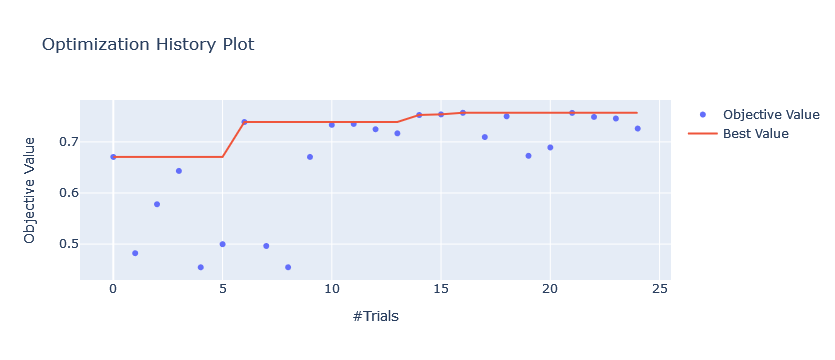

In [44]:
import plotly
from optuna.visualization import plot_optimization_history
plot_optimization_history(xgb_study)

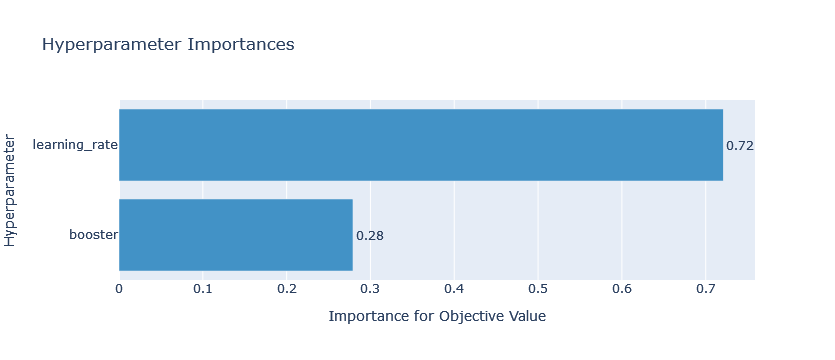

In [45]:
fig = optuna.visualization.plot_param_importances(xgb_study)
fig.show()

Now, you can carry on with saving the best model as described in the past notebook. 

## Summary

We saw how to implement Cohen's kappa in your daily modelling life. We also learned that we may use it to optimize your models. 

While kappa is an excellent metric, it is not perfect. You can read about its limitations in this blog by [Maarit Widmann](https://www.knime.com/blog/cohens-kappa-an-overview) under the section, "Pain Points of Cohen’s Kappa". There's also this [publication](https://doi.org/10.1371/journal.pone.0222916) which finds that using kappa for multi-class classification problems might not be the best strategy.